# Fair Energy Pricing for Residential DERs

## Team SolarCoders: Lucy Corthel, Arohi Patil, Siham Elmali,  Nima J Sherpa, Aaron Padilla

### November 23, 2025


## Initial Setup and Data Loading



In [30]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import numpy as np

sns.set_theme(style="whitegrid")

# Load the 'hrl_load_metered.csv' file into df_load_all
df_load_all = pd.read_csv('/content/hrl_load_metered.csv')

# Load the 'ATSI_LMP_2023_2026.csv' into df_price_all
df_price_all = pd.read_csv('https://raw.githubusercontent.com/Aaron-Padilla/SolarCoders-MITPolicyHackathon25/main/datasets/ATSI_LMP_2023_2026.csv')

# Display initial information for df_load_all
print("\n--- Info for df_load_all ---")
df_load_all.info()

# Display descriptive statistics for df_load_all
print("\n--- Descriptive statistics for df_load_all ---")
df_load_all.describe()


--- Info for df_load_all ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263520 entries, 0 to 263519
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   datetime_beginning_utc  263520 non-null  object 
 1   datetime_beginning_ept  263520 non-null  object 
 2   nerc_region             263520 non-null  object 
 3   mkt_region              263520 non-null  object 
 4   zone                    263520 non-null  object 
 5   load_area               263520 non-null  object 
 6   mw                      263520 non-null  float64
 7   is_verified             263520 non-null  bool   
dtypes: bool(1), float64(1), object(6)
memory usage: 14.3+ MB

--- Descriptive statistics for df_load_all ---


,mw
count,263520.000000
mean,6232.804703
std,16854.188689
min,0.000000
25%,673.951750
50%,2309.006000
75%,4670.853000
max,160154.429000


### Load Data

- `datetime_beginning_utc`: The date and time marking the start of the hour in Coordinated Universal Time (UTC). This is the global standard time and does not change for Daylight Saving Time.

- `datetime_beginning_ept`: The date and time marking the start of the hour in Eastern Prevailing Time (EPT). This is the local "wall clock" time used by the PJM grid, which switches between Standard Time (EST) and Daylight Time (EDT).

- `nerc_region`: The reliability region defined by the North American Electric Reliability Corporation.
  - Example:`RFC` stands for "ReliabilityFirst Corporation," which covers the Great Lakes and Mid-Atlantic area.


- `mkt_region`: The specific market region within the PJM grid.

    - Example: `WEST` (Western PJM, like Ohio) or MIDATL (Mid-Atlantic).

- `zone`: The Transmission Zone. This usually corresponds to the service territory of a major utility company (like ATSI for FirstEnergy in Ohio or AEP for American Electric Power). This is the main geographic level for analyzing load.

- `load_area`: A specific sub-area or reporting entity within the Zone.

    - Example: Inside the `ATSI` zone, you might see OE (Ohio Edison) or PAPWR (Penn Power).

- `mw`: The amount of electricity load (demand) measured in Megawatts. This is the actual power being used during that hour.

- `is_verified`: A True/False flag indicating if this data point has been finalized.

    - True: The data is verified and final.

    - False: The data is preliminary and might be subject to minor corrections.

## ATSI Zone Load Data Preprocessing



In [31]:
# Filter dataset for ATSI zone then create a copy
df_atsi =  df_load_all[df_load_all['zone'] == 'ATSI'].copy()

# convert the datetime columns to datetime object with specified format
df_atsi['datetime_beginning_ept'] = pd.to_datetime(df_atsi['datetime_beginning_ept'], format="%m/%d/%Y %I:%M:%S %p")
df_atsi['datetime_beginning_utc'] = pd.to_datetime(df_atsi['datetime_beginning_utc'], format="%m/%d/%Y %I:%M:%S %p")

# Display the first 5 rows
df_atsi.head()

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
17,2024-10-31 04:00:00,2024-10-31 00:00:00,RFC,WEST,ATSI,OE,5786.902,True
19,2024-10-31 04:00:00,2024-10-31 00:00:00,RFC,WEST,ATSI,PAPWR,385.296,True
47,2024-10-31 05:00:00,2024-10-31 01:00:00,RFC,WEST,ATSI,OE,5589.089,True
49,2024-10-31 05:00:00,2024-10-31 01:00:00,RFC,WEST,ATSI,PAPWR,378.611,True
77,2024-10-31 06:00:00,2024-10-31 02:00:00,RFC,WEST,ATSI,OE,5505.691,True


## Hourly Load Profile Visualization (ATSI)

Generate a pivot table (`df_pivot`) showing hourly load for each `load_area` within the ATSI zone. Visualize this data with a line chart showing load over time, a stacked area chart for contribution to total load, and a line plot for the average hourly load profile.


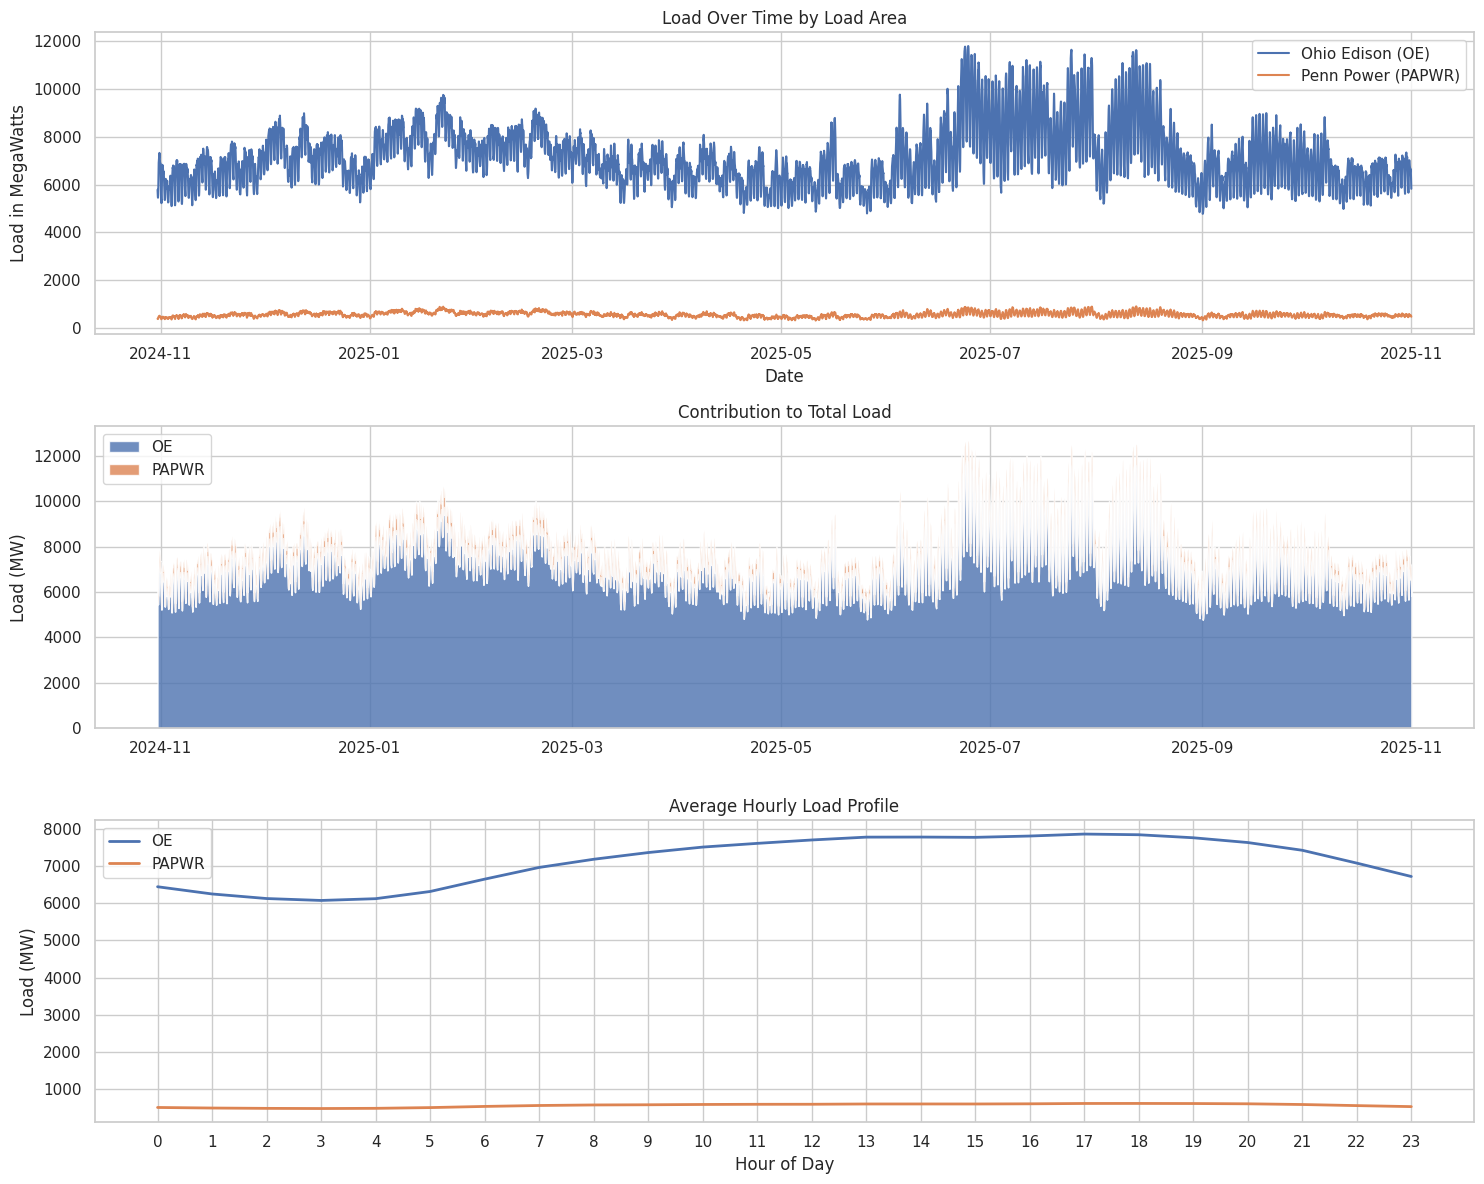

In [32]:
df_pivot = df_atsi.pivot_table(
    index='datetime_beginning_ept',
    columns='load_area',
    values='mw',
    aggfunc='mean'
)

# --- Plotting ---
plt.figure(figsize=(15, 12))

# Line Chart
plt.subplot(3, 1, 1)
plt.plot(df_pivot.index, df_pivot['OE'], label='Ohio Edison (OE)')
plt.plot(df_pivot.index, df_pivot['PAPWR'], label='Penn Power (PAPWR)')
plt.title('Load Over Time by Load Area')
plt.xlabel('Date')
plt.ylabel('Load in MegaWatts')
plt.legend()

# Stacked Area Chart
plt.subplot(3, 1, 2)
plt.stackplot(df_pivot.index, df_pivot['OE'], df_pivot['PAPWR'], labels=['OE', 'PAPWR'], alpha=0.8)
plt.title('Contribution to Total Load')
plt.ylabel('Load (MW)')
plt.legend(loc='upper left')

# Hourly Average Profile
plt.subplot(3, 1, 3)
# Extract hour for grouping
df_atsi['hour'] = df_atsi['datetime_beginning_ept'].dt.hour
hourly_avg = df_atsi.groupby(['hour', 'load_area'])['mw'].mean().unstack()

plt.plot(hourly_avg.index, hourly_avg['OE'], label='OE', linewidth=2)
plt.plot(hourly_avg.index, hourly_avg['PAPWR'], label='PAPWR', linewidth=2)
plt.title('Average Hourly Load Profile')
plt.xlabel('Hour of Day')
plt.ylabel('Load (MW)')
plt.legend()
plt.xticks(range(0, 24))

plt.tight_layout()
plt.show()

## Overall Hourly Load Patterns (ATSI)

Calculate the total ATSI load by summing `mw` for each timestamp. Visualize the overall hourly load patterns using a heatmap to show intensity, a boxplot to display variability by hour, and a 'spaghetti plot' to overlay daily load profiles with an average trend line.


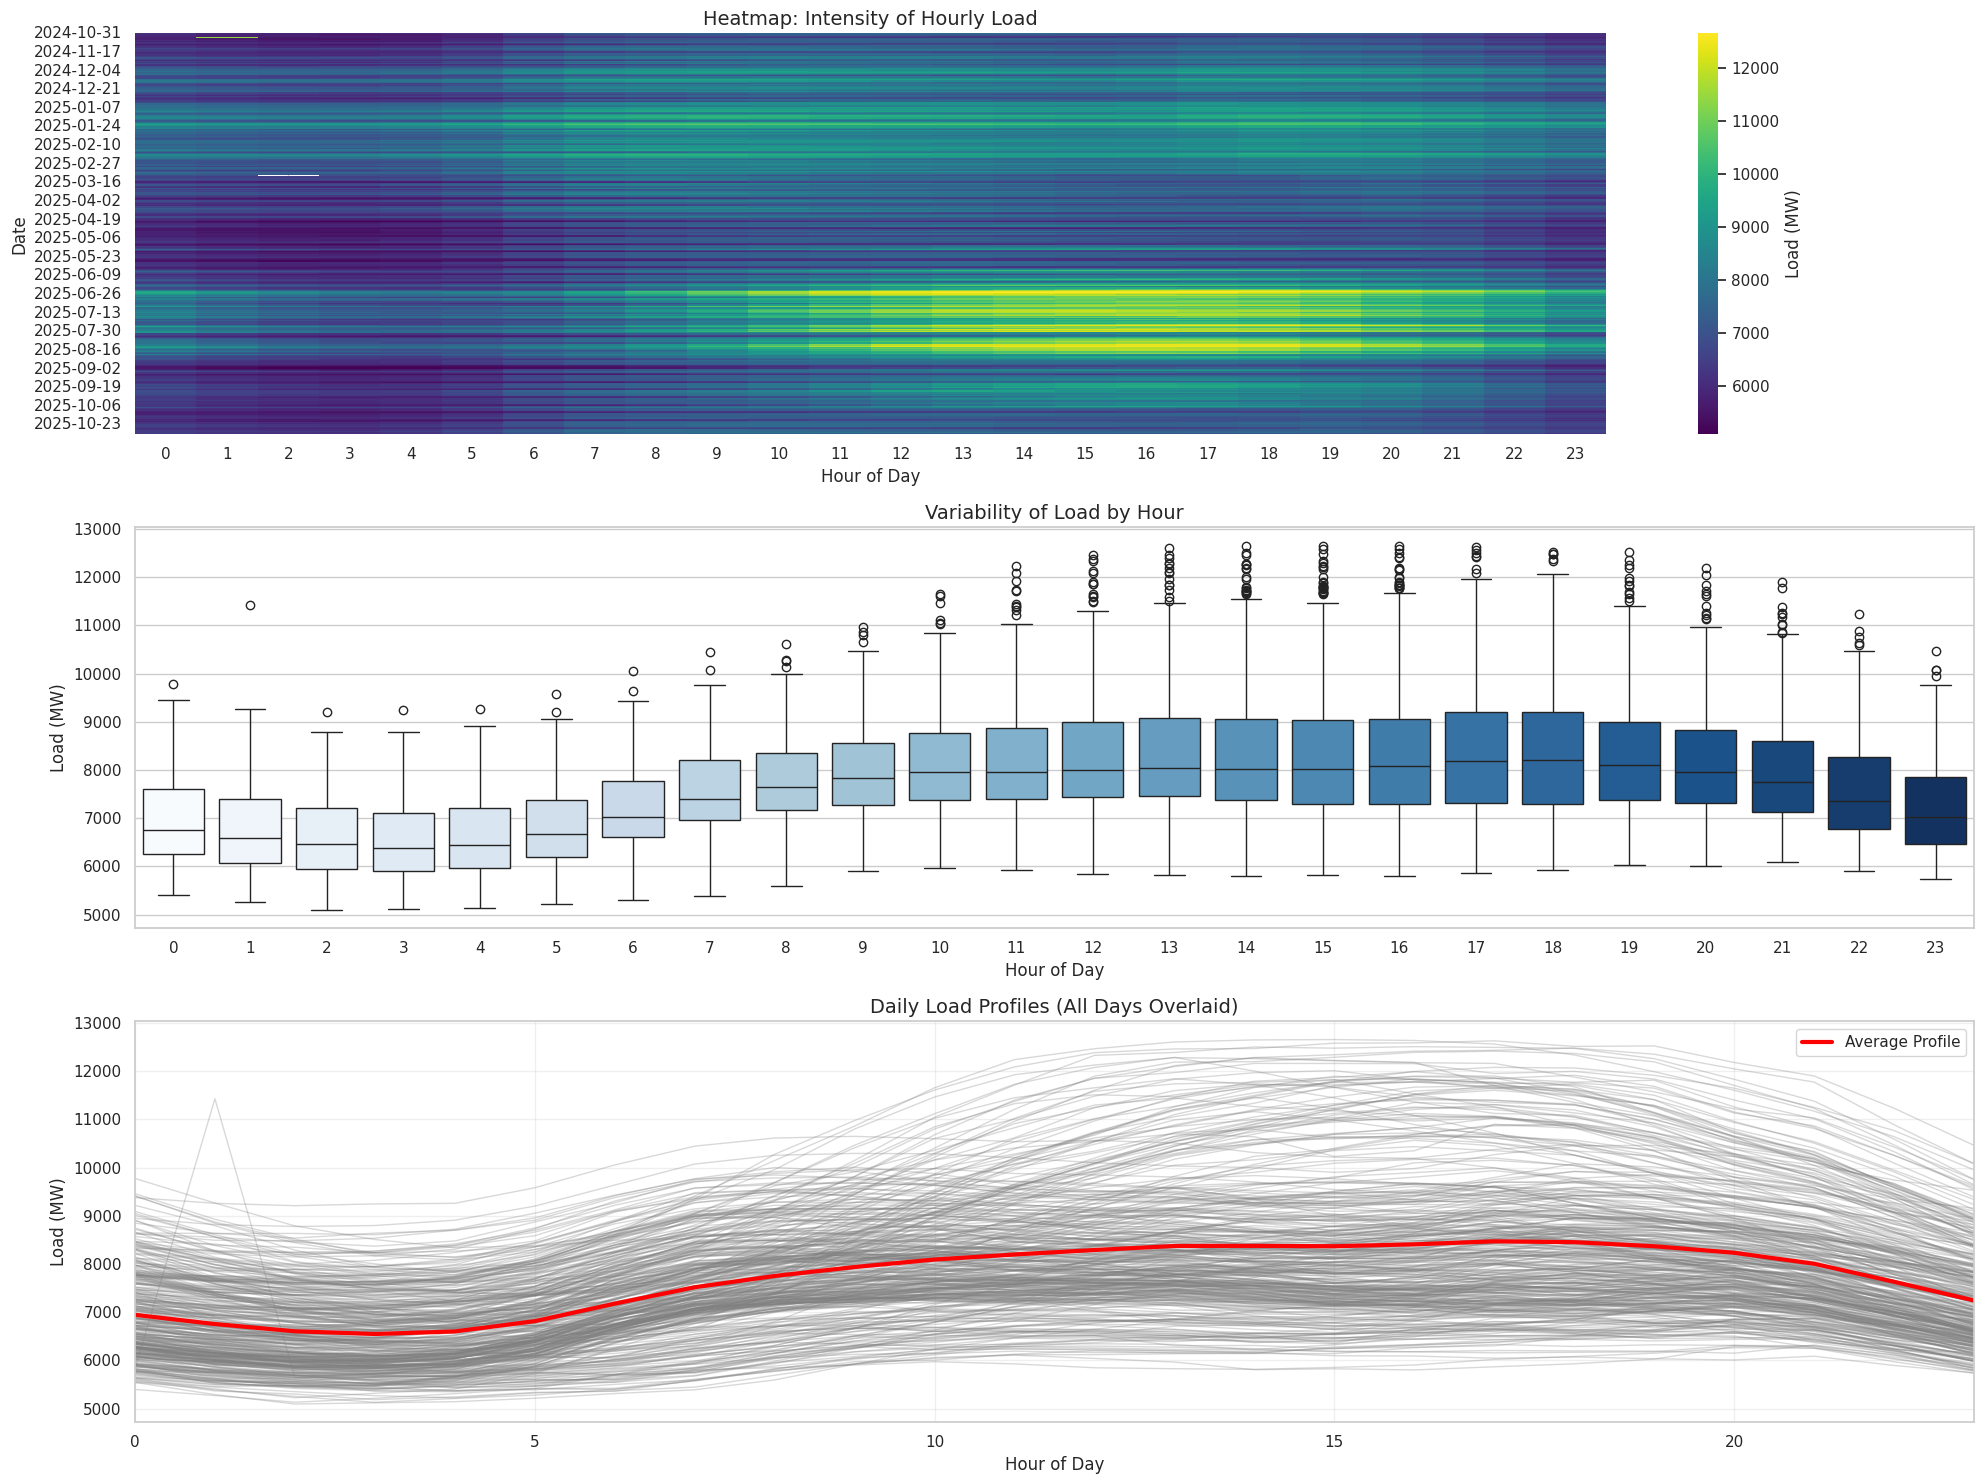

In [33]:
import matplotlib.ticker as ticker

# Group by timestamp to sum the load from all sub-areas (Total ATSI Load)
df_atsi_total = df_atsi.groupby('datetime_beginning_ept')['mw'].sum().to_frame()

# Extract Date and Hour
df_atsi_total['date'] = df_atsi_total.index.date
df_atsi_total['hour'] = df_atsi_total.index.hour

# Create a Pivot Table (Rows=Date, Cols=Hour, Values=MW)
pivot_table = df_atsi_total.pivot_table(index='date', columns='hour', values='mw')

# --- Plotting ---
plt.figure(figsize=(20, 15))

# 1. Heatmap
plt.subplot(3, 1, 1)
sns.heatmap(pivot_table, cmap='viridis', cbar_kws={'label': 'Load (MW)'})
plt.title('Heatmap: Intensity of Hourly Load', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Date')

# 2. Boxplot
plt.subplot(3, 1, 2)
sns.boxplot(x='hour', y='mw', data=df_atsi_total, hue='hour', palette="Blues", legend=False)
plt.title('Variability of Load by Hour', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Load (MW)')

# 3. Spaghetti Plot (Daily Profiles)
plt.subplot(3, 1, 3)
# Plot each day as a faint grey line
for date in pivot_table.index:
    plt.plot(pivot_table.columns, pivot_table.loc[date], alpha=0.3, color='gray', linewidth=1)

# Plot the average as a bold red line
plt.plot(pivot_table.columns, pivot_table.mean(axis=0), color='red', linewidth=3, label='Average Profile')

plt.title('Daily Load Profiles (All Days Overlaid)', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 23)

plt.tight_layout()
plt.show()

## Load vs. Price Data Preparation



In [34]:
# 1. Create a copy of df_load_all named df_load, renaming the column 'datetime_beginning_utc' to 'timestamp' and 'mw' to 'load_mw'.
df_load = df_load_all.copy().rename(columns={
    "datetime_beginning_utc": "timestamp",
    "mw": "load_mw"
})

# 2. Create a copy of df_price_all named df_price, renaming the column 'interval_start_utc' to 'timestamp' and 'lmp' to 'price_rt'.
df_price = df_price_all.copy().rename(columns={
    "interval_start_utc": "timestamp",
    "lmp": "price_rt"
})

# 3. Convert the 'timestamp' column in both df_load and df_price to datetime objects, specifying utc=True.
df_load["timestamp"] = pd.to_datetime(df_load["timestamp"], utc=True)
df_price["timestamp"] = pd.to_datetime(df_price["timestamp"], utc=True)

# 4. Filter df_load to include only rows where 'load_mw' is less than 25000.
df_load = df_load[df_load["load_mw"] < 25000]

# 5. Define the start date as "2024-12-31" and the end date as "2025-12-31".
start_date = "2024-12-31"
end_date = "2025-12-31"

# 6. Filter both df_load and df_price to retain only the data within the specified date range (inclusive).
df_load = df_load[(df_load["timestamp"] >= start_date) & (df_load["timestamp"] <= end_date)]
df_price = df_price[(df_price["timestamp"] >= start_date) & (df_price["timestamp"] <= end_date)]

# 7. Merge df_load (selecting 'timestamp' and 'load_mw' columns) and df_price (selecting 'timestamp' and 'price_rt' columns) into a new DataFrame called df_merged_analysis using an inner join on the 'timestamp' column.
df_merged_analysis = pd.merge(
    df_load[["timestamp", "load_mw"]],
    df_price[["timestamp", "price_rt"]],
    on="timestamp",
    how="inner"
)

# 8. Calculate a new column in df_merged_analysis named 'total_cost_usd' by multiplying the 'load_mw' column by the 'price_rt' column.
df_merged_analysis["total_cost_usd"] = (df_merged_analysis["load_mw"]) * df_merged_analysis["price_rt"]

# 9. Extract the full month name from the 'timestamp' column and store it in a new column called 'month_name' in df_merged_analysis.
df_merged_analysis["month_name"] = df_merged_analysis["timestamp"].dt.month_name()

# 10. Extract the hour from the 'timestamp' column and store it in a new column called 'hour' in df_merged_analysis.
df_merged_analysis["hour"] = df_merged_analysis["timestamp"].dt.hour

# 11. Display the first 5 rows of df_merged_analysis using the .head() method.
print("\n--- Head of df_merged_analysis ---")
print(df_merged_analysis.head())

# 12. Display the last 5 rows of df_merged_analysis using the .tail() method.
print("\n--- Tail of df_merged_analysis ---")
print(df_merged_analysis.tail())

# 13. Display descriptive statistics for df_merged_analysis using the .describe() method.
print("\n--- Descriptive Statistics for df_merged_analysis ---")
print(df_merged_analysis.describe())


--- Head of df_merged_analysis ---
                  timestamp   load_mw   price_rt  total_cost_usd month_name  \
0 2024-12-31 00:00:00+00:00  1097.668  20.297726    22280.164303   December   
1 2024-12-31 00:00:00+00:00  4506.584  20.297726    91473.407228   December   
2 2024-12-31 00:00:00+00:00  2947.255  20.297726    59822.574442   December   
3 2024-12-31 00:00:00+00:00   656.452  20.297726    13324.482828   December   
4 2024-12-31 00:00:00+00:00  7256.478  20.297726   147290.002169   December   

   hour  
0     0  
1     0  
2     0  
3     0  
4     0  

--- Tail of df_merged_analysis ---
                       timestamp   load_mw   price_rt  total_cost_usd  \
212391 2025-11-01 03:00:00+00:00  4091.774  36.276065   148433.459589   
212392 2025-11-01 03:00:00+00:00   129.112  36.276065     4683.675304   
212393 2025-11-01 03:00:00+00:00   319.538  36.276065    11591.581258   
212394 2025-11-01 03:00:00+00:00    99.039  36.276065     3592.745202   
212395 2025-11-01 03:00:00+0

## Load History and Daily Profiles

Visualize the long-term load history using a weekly average line plot and the average daily load profile using a line plot with error bars. Subsequently, analyze the average daily load profile by distinguishing between weekdays and weekends, and then further by season.

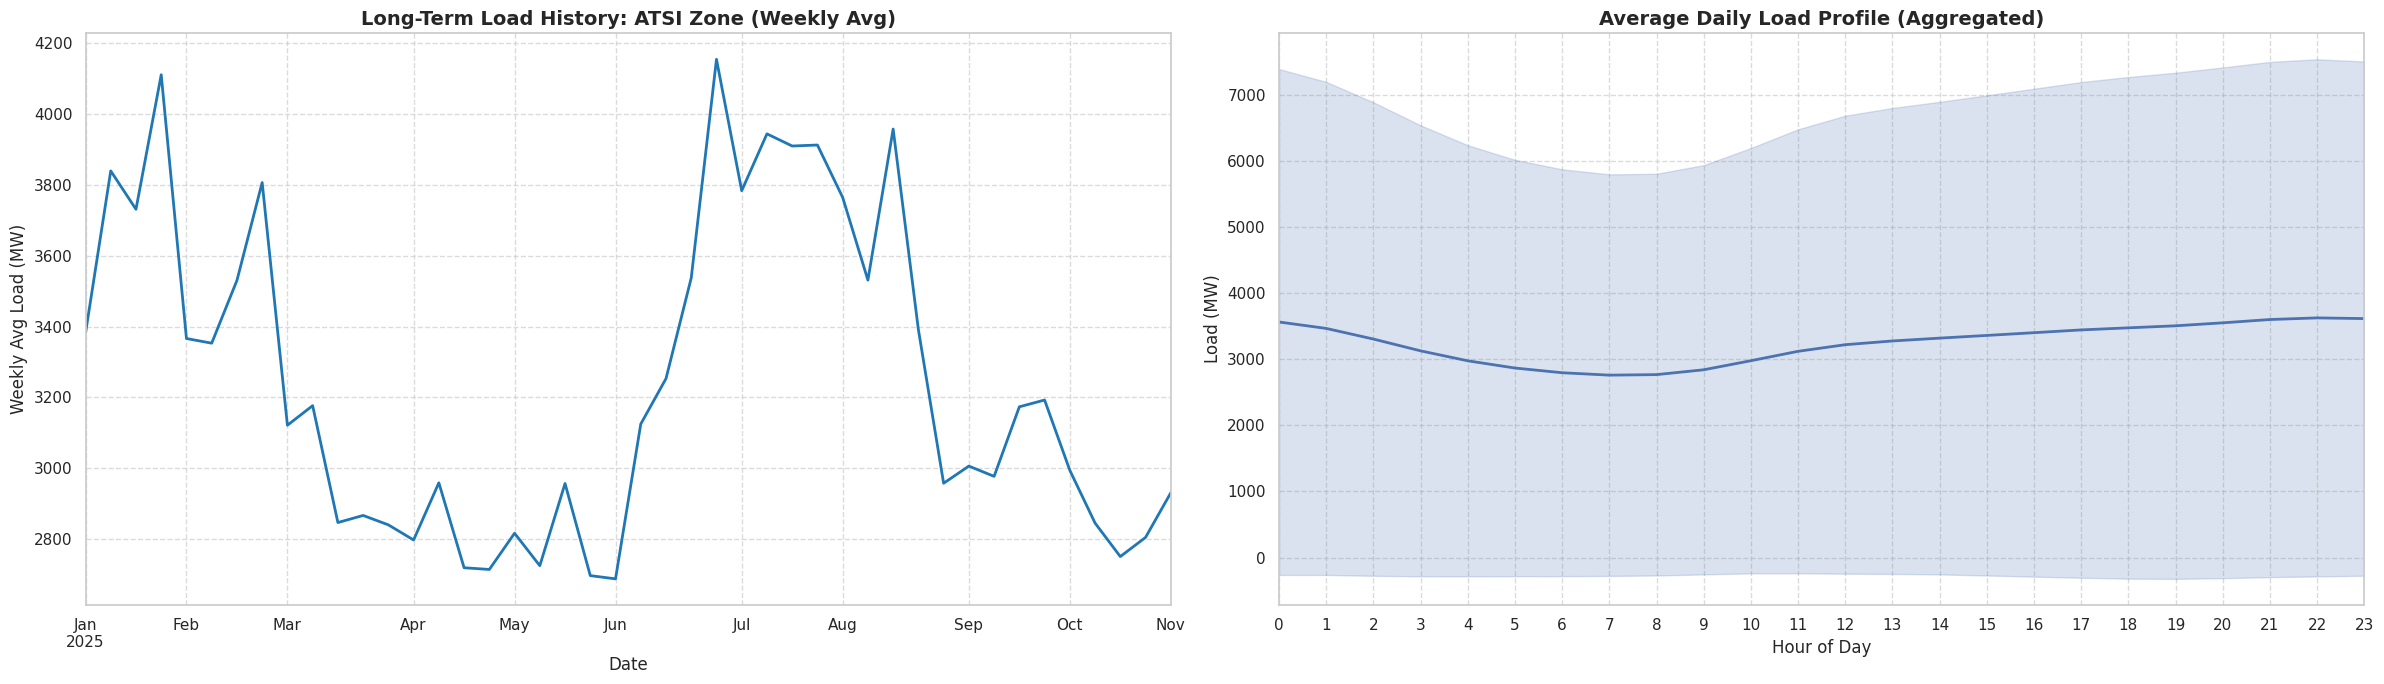

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(24, 7))

# Long-Term Load History (Weekly Average)
df_merged_analysis.set_index("timestamp").resample("W")["load_mw"].mean().plot(color="#1f77b4", ax=axes[0], linewidth=2)
axes[0].set_title("Long-Term Load History: ATSI Zone (Weekly Avg)", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Weekly Avg Load (MW)")
axes[0].set_xlabel("Date")
axes[0].grid(True, linestyle='--', alpha=0.7)

# Average Daily Profile (Aggregated)
sns.lineplot(data=df_merged_analysis, x="hour", y="load_mw", errorbar="sd", linewidth=2, ax=axes[1])
axes[1].set_title("Average Daily Load Profile (Aggregated)", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Load (MW)")
axes[1].set_xlabel("Hour of Day")
axes[1].set_xticks(range(0, 24))
axes[1].set_xlim(0, 23)
axes[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

To further analyze the average daily load profile as per the subtask, we create new column `is_weekend` in `df_merged_analysis` and then plot the average daily load profile, differentiating between weekdays and weekends.



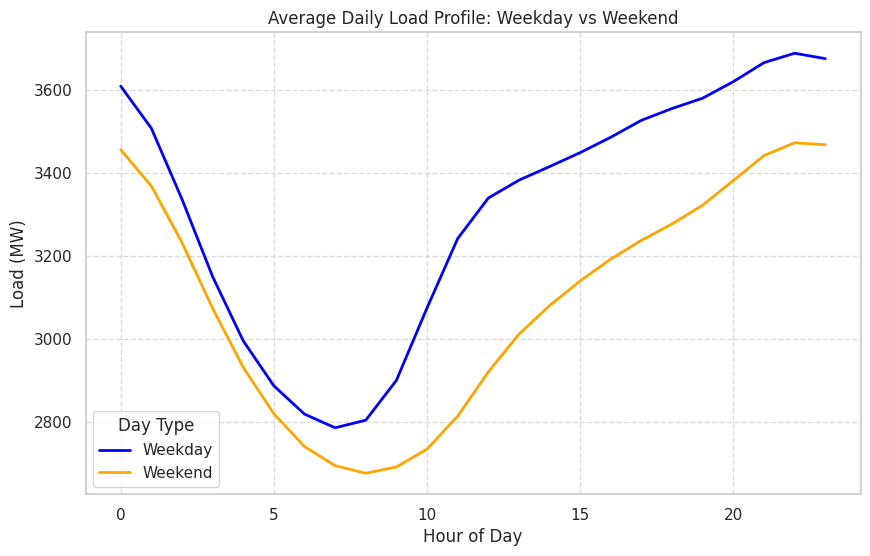

In [36]:
df_merged_analysis['is_weekend'] = df_merged_analysis['timestamp'].dt.dayofweek >= 5

plt.figure(figsize=(10, 6))

sns.lineplot(
    data=df_merged_analysis,
    x="hour",
    y="load_mw",
    hue="is_weekend",
    palette={True: "orange", False: "blue"},
    errorbar=None,
    linewidth=2
)


plt.title("Average Daily Load Profile: Weekday vs Weekend")
plt.ylabel("Load (MW)")
plt.xlabel("Hour of Day")
plt.legend(title="Day Type", labels=['Weekday', 'Weekend'])
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

We create a `season` column in `df_merged_analysis` by mapping the `month_name` to appropriate seasons and then generate a line plot to visualize the average daily load profile for each season.



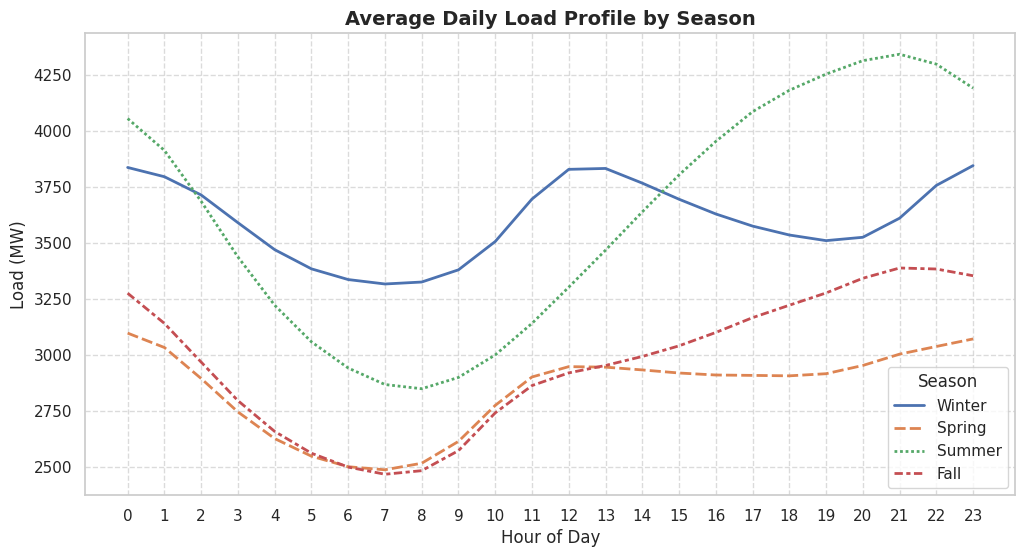

In [37]:
season_map = {
    'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
    'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
    'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
    'September': 'Fall', 'October': 'Fall', 'November': 'Fall'
}

df_merged_analysis['season'] = df_merged_analysis['month_name'].map(season_map)

plt.figure(figsize=(12, 6))

sns.lineplot(
    data=df_merged_analysis,
    x="hour",
    y="load_mw",
    hue="season",
    style="season",
    errorbar=None,
    linewidth=2
)

plt.title("Average Daily Load Profile by Season", fontsize=14, fontweight='bold')
plt.ylabel("Load (MW)")
plt.xlabel("Hour of Day")
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Season")

plt.show()

## Electricity Price Analysis (Overall)



We analyze electricity price trends by creating two plots:
- one showing overall hourly and daily average prices in $\$/MWh$,
- And another focusing on 2025 hourly and daily average prices in $\$/kWh$


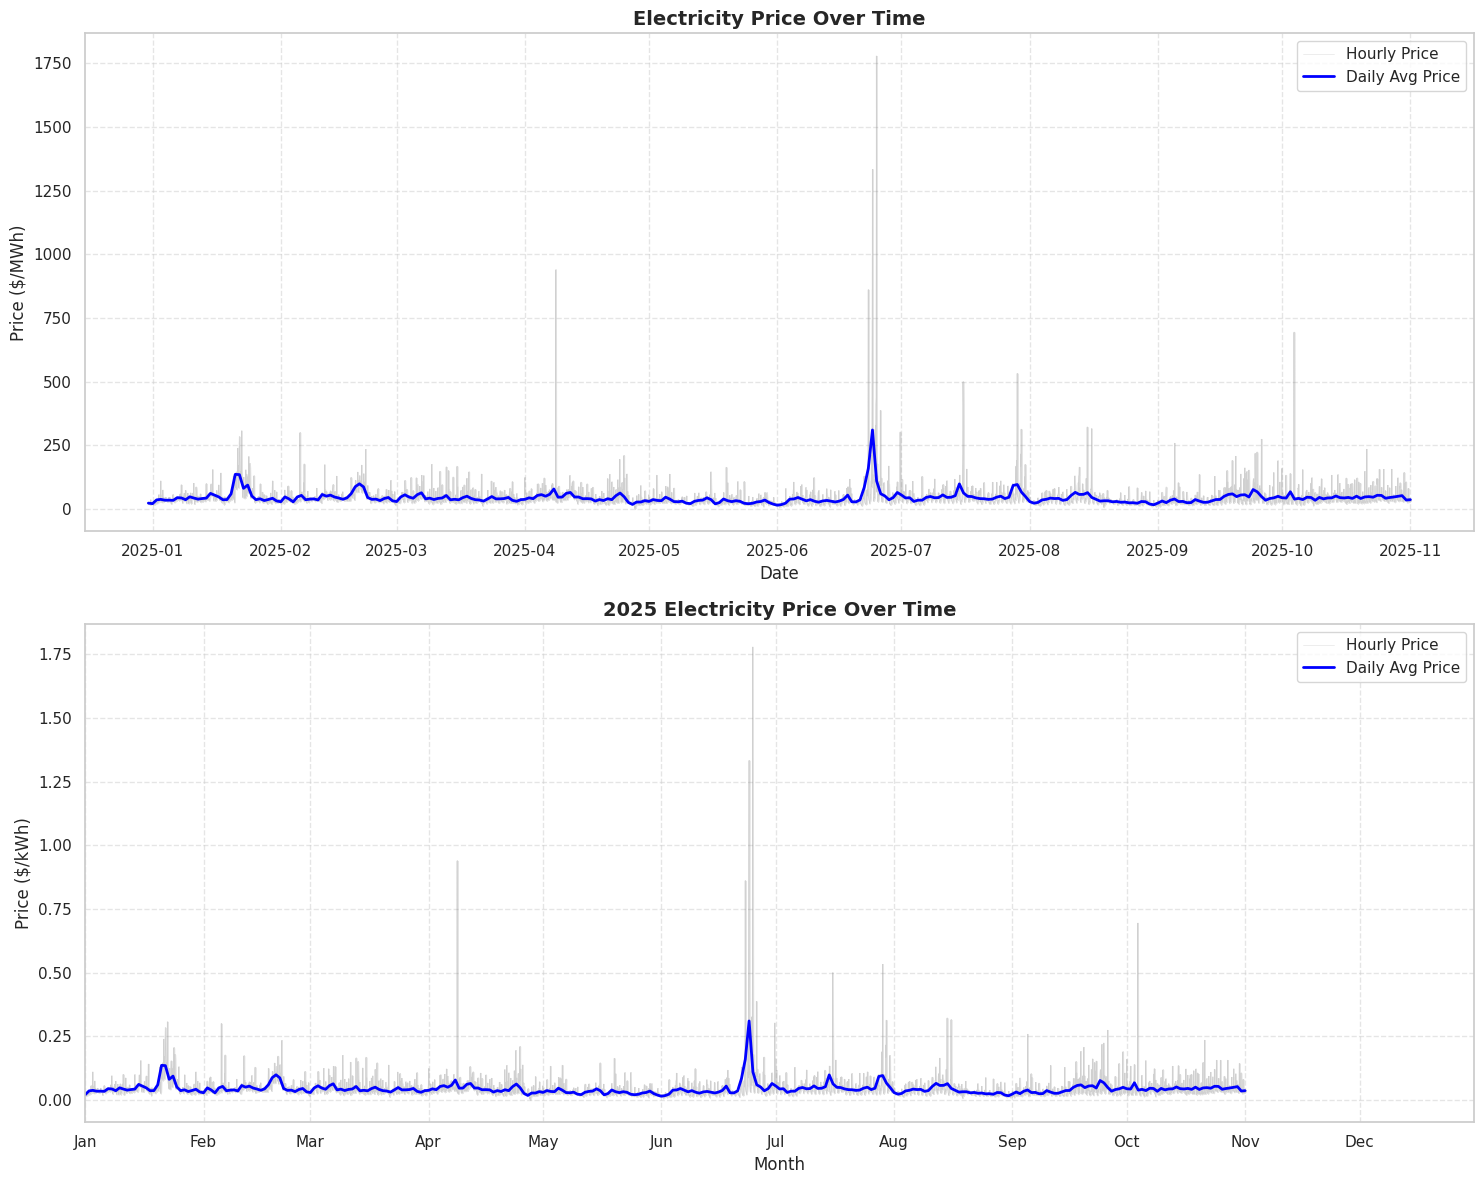

In [27]:
# 1. Calculate the daily average of price_rt
df_daily_price = df_merged_analysis.set_index('timestamp').resample('D')['price_rt'].mean().reset_index()

# 2. Create a figure with a suitable size for two subplots.
plt.figure(figsize=(15, 12))

# 3 & 4. First subplot: Overall Electricity Price Over Time ($/MWh)
plt.subplot(2, 1, 1)
sns.lineplot(
    data=df_merged_analysis,
    x="timestamp",
    y="price_rt",
    color='grey',
    alpha=0.2,
    linewidth=0.5,
    label='Hourly Price'
)
sns.lineplot(
    data=df_daily_price,
    x="timestamp",
    y="price_rt",
    color='blue',
    linewidth=2,
    label='Daily Avg Price'
)
plt.title("Electricity Price Over Time", fontsize=14, fontweight='bold')
plt.ylabel("Price ($/MWh)")
plt.xlabel("Date")
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

# 5. Create new column price_kwh
df_merged_analysis["price_kwh"] = df_merged_analysis["price_rt"] / 1000

# 6. Filter df_merged_analysis for 2025 data
start_plot = "2025-01-01"
end_plot = "2025-12-31"
plot_df = df_merged_analysis[(df_merged_analysis["timestamp"] >= start_plot) & (df_merged_analysis["timestamp"] <= end_plot)].copy()

# 7. Calculate daily average of price_kwh for 2025
df_daily_kwh = plot_df.set_index('timestamp').resample('D')['price_kwh'].mean().reset_index()

# 8, 9 & 10. Second subplot: 2025 Electricity Price Over Time ($/kWh)
plt.subplot(2, 1, 2)
sns.lineplot(
    data=plot_df,
    x="timestamp",
    y="price_kwh",
    color='grey',
    alpha=0.2,
    linewidth=0.5,
    label='Hourly Price'
)
sns.lineplot(
    data=df_daily_kwh,
    x="timestamp",
    y="price_kwh",
    color='blue',
    linewidth=2,
    label='Daily Avg Price'
)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xlim(pd.Timestamp("2025-01-01"), pd.Timestamp("2025-12-31"))
plt.title("2025 Electricity Price Over Time", fontsize=14, fontweight='bold')
plt.ylabel("Price ($/kWh)")
plt.xlabel("Month")
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

# 11. Ensure both plots are neatly arranged and displayed.
plt.tight_layout()
plt.show()

## Cost and Price Impact (Overall)

Visualize the cost and price impact using a calendar heatmap to show median price by time of day across months and a bar chart to illustrate the total estimated market cost per month.


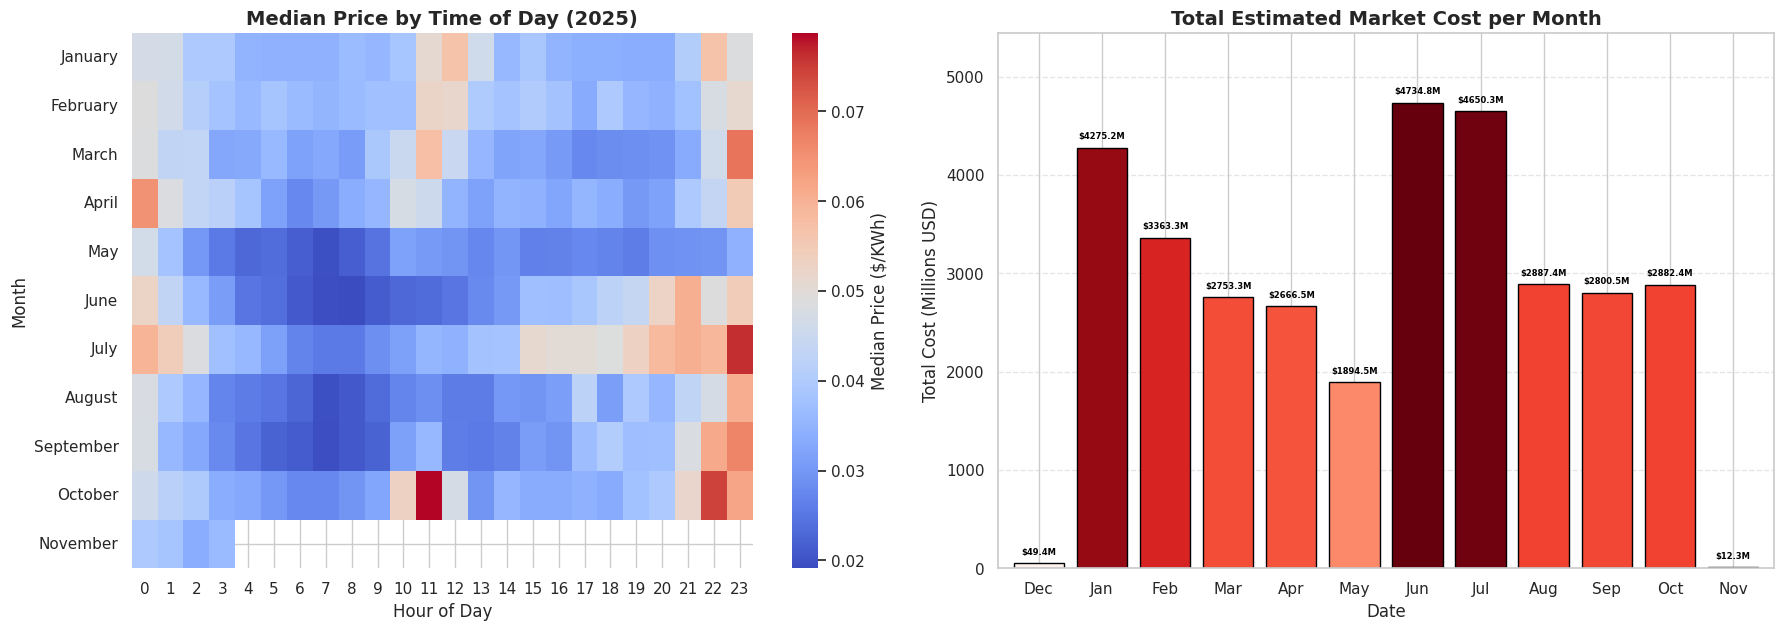

In [28]:
df_merged_analysis["price_kwh"] = df_merged_analysis["price_rt"] / 1000

# Calculate Monthly Aggregates for the Bar Chart
monthly_cost = df_merged_analysis.set_index("timestamp").resample("ME")["total_cost_usd"].sum() / 1_000_000

# Setup Colors for the Bars
norm = plt.Normalize(monthly_cost.min(), monthly_cost.max())
colors = plt.cm.Reds(norm(monthly_cost.values))

# 2. Generate Plots
# -----------------
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2)

# Calendar Heatmap
ax1 = fig.add_subplot(gs[0, 0])
heatmap_data = df_merged_analysis.pivot_table(index="month_name", columns="hour", values="price_kwh", aggfunc="median")
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November']
heatmap_data = heatmap_data.reindex(month_order)

sns.heatmap(heatmap_data, cmap="coolwarm", ax=ax1, cbar_kws={'label': 'Median Price ($/KWh)'})
ax1.set_title("Median Price by Time of Day (2025)", fontsize=14, fontweight='bold')
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Month")

# Total Estimated Spend
ax2 = fig.add_subplot(gs[0, 1])
monthly_cost.plot(kind="bar", ax=ax2, color=colors, edgecolor="black", width=0.8)

for p in ax2.patches:
    value = p.get_height()
    # Format as "$123.4M"
    ax2.annotate(f'${value:.1f}M',
                 (p.get_x() + p.get_width() / 2., value),
                 ha='center', va='bottom',
                 fontsize=6, fontweight='bold', color='black',
                 xytext=(0, 5), textcoords='offset points')

ax2.set_title("Total Estimated Market Cost per Month", fontsize=14, fontweight='bold')
ax2.set_ylabel("Total Cost (Millions USD)")
ax2.set_xlabel("Date")
ax2.set_xticklabels([x.strftime('%b') for x in monthly_cost.index], rotation=0)
ax2.grid(axis='y', linestyle='--', alpha=0.5)
ax2.set_ylim(0, monthly_cost.max() * 1.15)

plt.tight_layout()
plt.show()


# Ohio case study: Solar Project Financial Impact: 50-Year Projection

Analyze the financial impact of a solar project over a 50-year timeline, comparing two scenarios: one with a 'Rider E' charge and one without. This analysis uses hardcoded capital cost and savings to project net profit/loss and breakeven points, and visualizes the results.


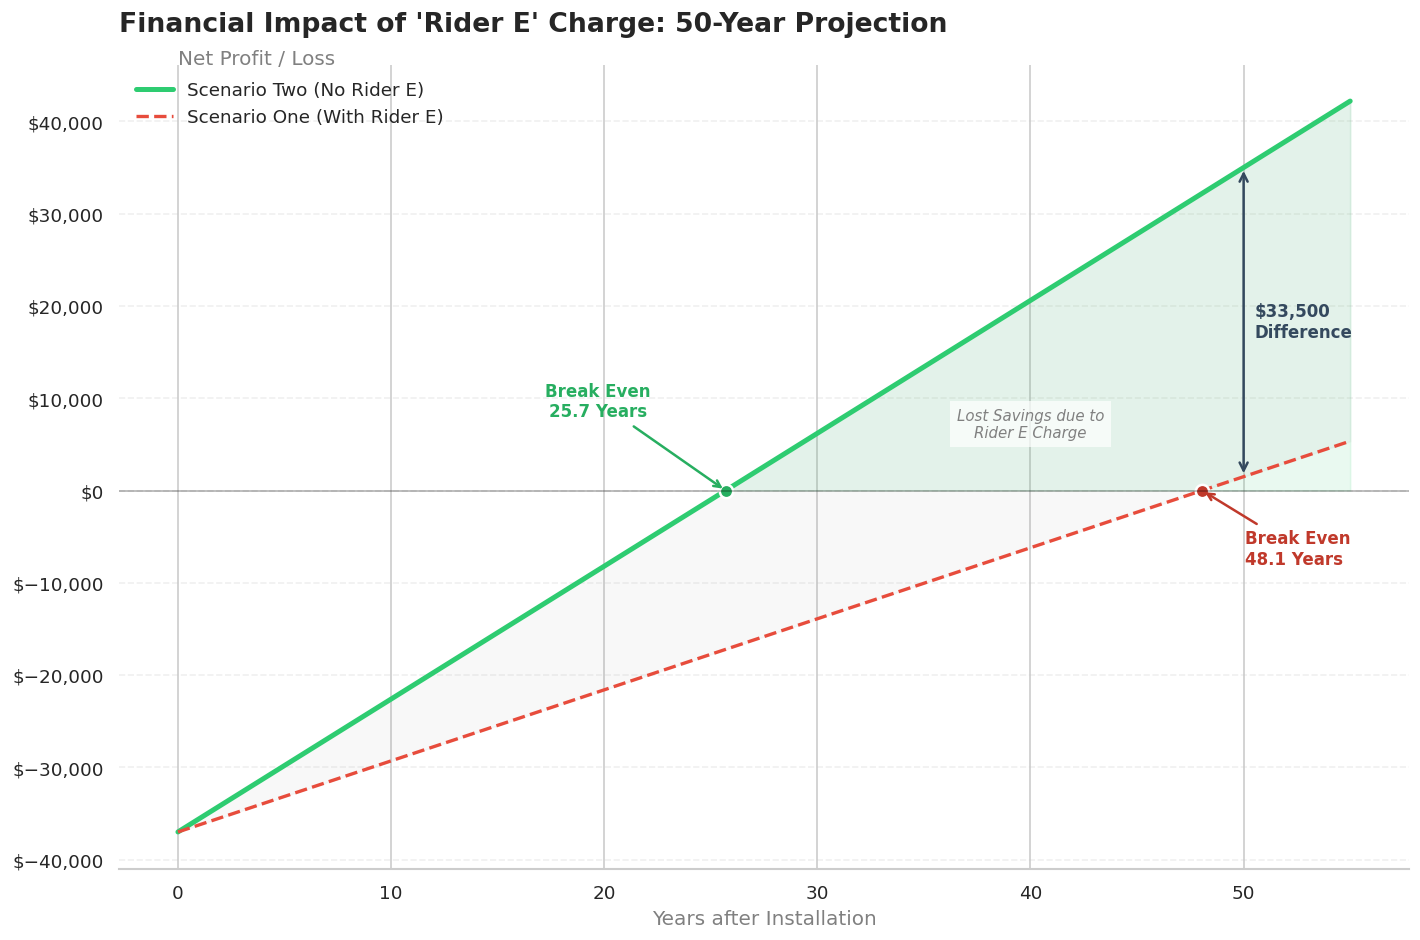

In [41]:
# 1. Define the capital_cost (e.g., 37000), savings_s1 (e.g., 770 for Scenario 1 with Rider E), and savings_s2 (e.g., 1440 for Scenario 2 without Rider E).
capital_cost = 37000
savings_s1 = 770   # Scenario 1 (With Rider E)
savings_s2 = 1440  # Scenario 2 (No Rider E)

# 2. Create a years array representing a 55-year timeline (from 0 to 55).
years = np.arange(0, 56)

# 3. Calculate the balance_s1 and balance_s2 over the years by subtracting the capital_cost and adding cumulative savings for each scenario.
balance_s1 = -capital_cost + (savings_s1 * years)
balance_s2 = -capital_cost + (savings_s2 * years)

# 4. Set up a Matplotlib figure with a specified size and DPI.
plt.rcParams['font.family'] = 'sans-serif'
fig, ax = plt.subplots(figsize=(12, 8), dpi=120)

# 5. Plot balance_s2 (Scenario 2) as a solid line and fill the area below it when the balance is positive. Label this 'Scenario Two (No Rider E)'.
ax.plot(years, balance_s2, color='#2ecc71', linewidth=3, label='Scenario Two (No Rider E)')
ax.fill_between(years, balance_s2, 0, where=(balance_s2 >= 0), color='#2ecc71', alpha=0.1, interpolate=True)

# 6. Plot balance_s1 (Scenario 1) as a dashed line. Label this 'Scenario One (With Rider E)'.
ax.plot(years, balance_s1, color='#e74c3c', linewidth=2, linestyle='--', label='Scenario One (With Rider E)')

# 7. Fill the area between balance_s2 and balance_s1 to represent 'Lost Savings due to Rider E Charge'.
ax.fill_between(years, balance_s2, balance_s1, color='grey', alpha=0.05, interpolate=True)

# 8. Calculate and annotate the breakeven points for both scenarios on the plot, indicating the number of years.
# S2 Breakeven
be_s2 = capital_cost / savings_s2
ax.plot(be_s2, 0, 'o', color='#27ae60', markersize=8, markeredgecolor='white', markeredgewidth=1.5)
ax.annotate(f'Break Even\n{be_s2:.1f} Years',
            xy=(be_s2, 0), xytext=(be_s2 - 6, 8000),
            arrowprops=dict(arrowstyle='->', color='#27ae60', lw=1.5),
            color='#27ae60', fontsize=10, fontweight='bold', ha='center')

# S1 Breakeven
be_s1 = capital_cost / savings_s1
ax.plot(be_s1, 0, 'o', color='#c0392b', markersize=8, markeredgecolor='white', markeredgewidth=1.5)
ax.annotate(f'Break Even\n{be_s1:.1f} Years',
            xy=(be_s1, 0), xytext=(be_s1 + 2, -8000),
            arrowprops=dict(arrowstyle='->', color='#c0392b', lw=1.5),
            color='#c0392b', fontsize=10, fontweight='bold', ha='left')

# 9. Annotate the difference in total balance between the two scenarios at year 50, showing the monetary value.
mid_year = 40
mid_val = (balance_s1[mid_year] + balance_s2[mid_year]) / 2
ax.text(mid_year, mid_val, "Lost Savings due to\nRider E Charge",
        fontsize=9, color='grey', ha='center', va='center', style='italic',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

gap_s2 = balance_s2[50]
gap_s1 = balance_s1[50]
diff = gap_s2 - gap_s1
ax.annotate(f'', xy=(50, gap_s1), xytext=(50, gap_s2),
            arrowprops=dict(arrowstyle='<->', color='#34495e', lw=1.5))
ax.text(50.5, (gap_s1 + gap_s2)/2, f'${diff:,.0f}\nDifference',
        fontsize=10, color='#34495e', fontweight='bold', va='center')


# 10. Add styling to the plot: remove top, right, and left spines, add a horizontal line at y=0, format y-axis labels as currency, set the title, x-label, and a y-axis description.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.axhline(0, color='black', linewidth=1, alpha=0.3)

fmt = ticker.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(fmt)

ax.set_title("Financial Impact of 'Rider E' Charge: 50-Year Projection", fontsize=16, fontweight='bold', pad=20, loc='left')
ax.set_xlabel("Years after Installation", fontsize=12, color='grey')
ax.text(0, ax.get_ylim()[1], "Net Profit / Loss", fontsize=12, color='grey')

# 11. Add a grid and a legend to the plot.
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.legend(frameon=False, loc='upper left', fontsize=11)

# 12. Ensure a tight layout and display the plot.
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   **Initial Data Overview (ATSI Load)**: The `df_load_all` dataset contains 263,520 entries with no missing values. The `mw` (megawatts) column shows a wide range, from 0.0 MW to 160,154.43 MW, with a mean of approximately 6,232.8 MW, indicating significant variability in load.
*   **ATSI Zone Load Patterns**:
    *   The ATSI zone's load is primarily driven by 'OE' (Ohio Edison) and 'PAPWR' (Penn Power), with both showing distinct hourly load profiles, typically peaking in the morning and late afternoon/evening.
    *   Overall hourly load patterns reveal significant variability, with peak loads often occurring during specific hours of the day. A heatmap visualization indicated periods of higher load intensity across different dates and hours.
*   **Load Demand by Time and Season**:
    *   **Daily Load Profile**: An aggregated average daily load profile shows clear peaks and troughs throughout the 24-hour cycle.
    *   **Weekday vs. Weekend**: Weekday load profiles generally exhibit higher demand and more pronounced peaks compared to weekends, which tend to have a flatter load curve.
    *   **Seasonal Variation**: Load demand varies significantly by season, with distinct daily profiles observed for Winter, Spring, Summer, and Fall, reflecting seasonal energy consumption behaviors (e.g., higher peaks in summer due to cooling, or winter due to heating).
*   **Electricity Price Trends**:
    *   Electricity prices (in \$/MWh) show considerable hourly fluctuation, with daily average prices providing a smoother trend.
    *   When converted to \$/kWh, the 2025 data reveals similar hourly and daily average patterns, allowing for a more granular understanding of price at the consumer level.
    *   A calendar heatmap of median prices in \$/kWh by hour and month shows that prices can vary significantly throughout the year and within a day, highlighting periods of high and low electricity costs.
*   **Estimated Market Cost**: The total estimated market cost (load * price) varies significantly month-to-month, with some months incurring substantially higher costs (e.g., December and July in the 2025 projection) compared to others, reaching up to approximately \$145.4M in peak months.
*   **Solar Project Financial Impact (50-Year Projection)**:
    *   **Scenario Two (No Rider E)**, with an annual saving of \$1,440, is projected to break even in approximately 25.7 years, leading to a substantial net profit over 50 years.
    *   **Scenario One (With Rider E)**, with reduced annual saving of \$770, is projected to break even much later, at approximately 48.1 years.
    *   The "Rider E" charge significantly impacts profitability, resulting in lost savings of approximately \$33,500 over 50 years compared to the no 'Rider E' scenario.

### Insights or Next Steps

*   **Optimized Solar Operations**: Given the clear hourly, daily, and seasonal load and price patterns, a solar project could significantly increase its financial returns by implementing strategies such as battery storage to sell power back to the grid during high-price, high-demand periods (e.g., summer afternoons, peak weekday hours) and reduce grid reliance during similar costly periods.
*   **Policy Advocacy for 'Rider E'**: The significant financial impact of the 'Rider E' charge (delaying breakeven by over 22 years and costing \$33,500 over 50 years) highlights a critical barrier to solar project viability. Further analysis and advocacy could focus on understanding the justification for 'Rider E' and exploring policy adjustments or incentives to mitigate its negative effects on renewable energy adoption.
